# Projet Risque de Crédit et Méthodes de Scoring
Par Arthur Ernoul de la Provoté, Florian Crochet, Isaline Hervé - M2 ECAP

In [24]:
import pandas as pd
from pathlib import Path
import openpyxl as oxl
import numpy as np
#import pkg_resources
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from scipy.stats import t
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, roc_curve, f1_score, precision_score,
    recall_score
)
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV

In [38]:
# --- Import des données ---
df = pd.read_excel(Path("data") / "credit.xlsx")
df.info()
# 1000 lignes, 21 colonnes
# 12 colonnes numériques (int64), 9 non numériques (object)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Cle                  1000 non-null   int64 
 1   Comptes              1000 non-null   int64 
 2   Duree_credit         1000 non-null   int64 
 3   Historique_credit    1000 non-null   object
 4   Objet_credit         1000 non-null   object
 5   Montant_credit       1000 non-null   int64 
 6   Epargne              1000 non-null   int64 
 7   Anciennete_emploi    1000 non-null   int64 
 8   Taux_effort          1000 non-null   int64 
 9   Situation_familiale  1000 non-null   object
 10  Garanties            1000 non-null   object
 11  Anciennete_domicile  1000 non-null   int64 
 12  Biens                1000 non-null   object
 13  Age                  1000 non-null   int64 
 14  Autres_credits       1000 non-null   object
 15  Statut_domicile      1000 non-null   object
 16  Nb_cred

In [39]:
# Encodage de la variable cible : 1 -> 0, 2 -> 1 
df["Cible"] = df["Cible"].map({1: 0, 2: 1})
df["Cible"].value_counts()

Cible
0    700
1    300
Name: count, dtype: int64

In [40]:
# Mise au format "category" pour les variables catégorielles
for col in df.select_dtypes('object').columns:
    df[col] = df[col].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Cle                  1000 non-null   int64   
 1   Comptes              1000 non-null   int64   
 2   Duree_credit         1000 non-null   int64   
 3   Historique_credit    1000 non-null   category
 4   Objet_credit         1000 non-null   category
 5   Montant_credit       1000 non-null   int64   
 6   Epargne              1000 non-null   int64   
 7   Anciennete_emploi    1000 non-null   int64   
 8   Taux_effort          1000 non-null   int64   
 9   Situation_familiale  1000 non-null   category
 10  Garanties            1000 non-null   category
 11  Anciennete_domicile  1000 non-null   int64   
 12  Biens                1000 non-null   category
 13  Age                  1000 non-null   int64   
 14  Autres_credits       1000 non-null   category
 15  Statut_domicile      1

## --- Statistiques descriptives ---

In [ ]:
# Aperçu des statistiques générales
ProfileReport(df, title="Rapport de données - Crédit")
# Pas de valeurs manquantes
# Garanties -> imbalanced
# Distributions semblent fortement assymétriques

# Corrélations fortes :
# entre Biens et Statut_domicile
# Montant_credit et Duree_credit

# Beaucoup de variables catégorielles malgré des chiffres dans les valeurs

In [41]:
# Sélection des variables numériques et variables catégorielles
# Cle à exclure (car identification de l'observation)
# Variables numériques : Age, Montant_credit, Duree_credit
# Variables catégorielles : toutes les autres
var_num = df[["Age", "Montant_credit", "Duree_credit"]]
var_cat = df.drop(columns=["Cle", "Age", "Montant_credit", "Duree_credit"])

In [42]:
# Statistiques descriptives - Univariées - Variables numériques
print("Statistiques descriptives variables numériques :")
var_num.describe()
# On observe un important écart-type pour Montant_Credit -> potentiellement des valeurs aberrantes

Statistiques descriptives variables numériques :


,Age,Montant_credit,Duree_credit
count,1000.000000,1000.000000,1000.000000
mean,35.546000,3271.258000,20.903000
std,11.375469,2822.736876,12.058814
min,19.000000,250.000000,4.000000
25%,27.000000,1365.500000,12.000000
50%,33.000000,2319.500000,18.000000
75%,42.000000,3972.250000,24.000000
max,75.000000,18424.000000,72.000000


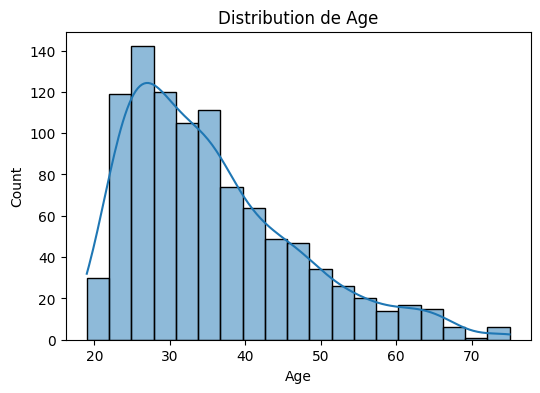

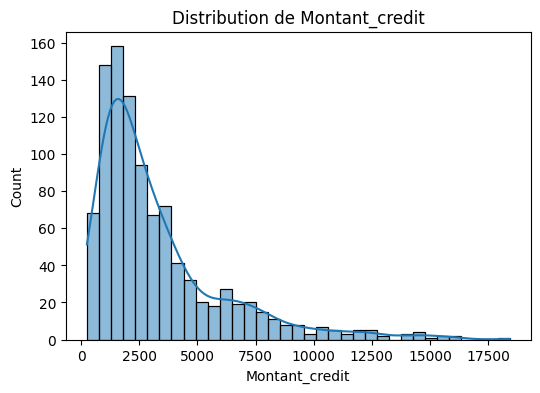

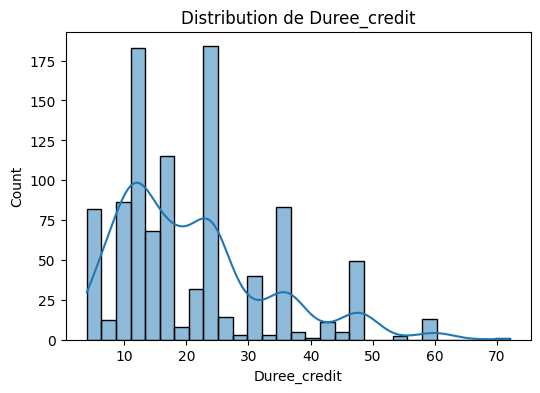

In [43]:
# Distributions
for col in var_num.columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(var_num[col], kde=True)
    plt.title(f"Distribution de {col}")
    plt.show()
# Asymétrie pour Age, Montant_credit, et distribution irrégulière et asymétrique pour Duree_credit

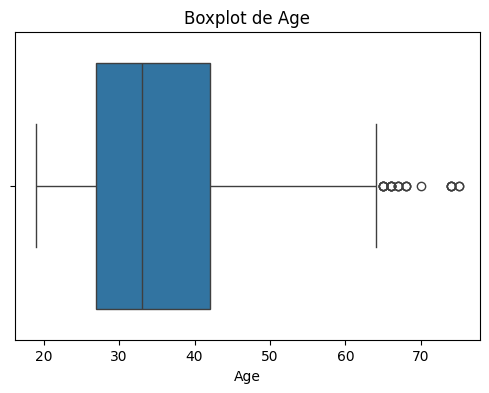

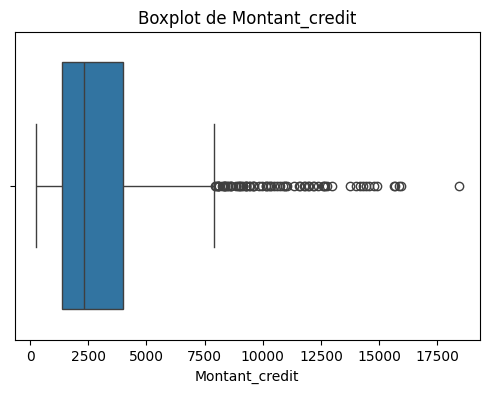

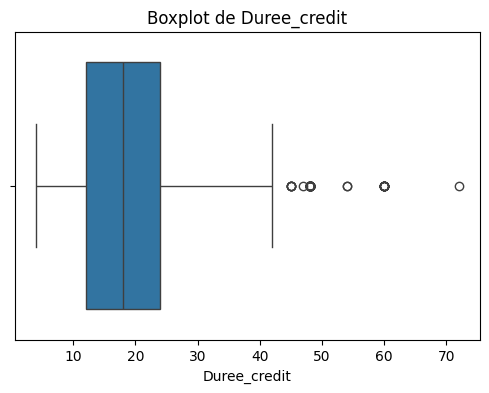

In [44]:
# Valeur aberrantes
# Boxplot
for col in var_num.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=var_num[col])
    plt.title(f"Boxplot de {col}")
    plt.show()
# 13 valeurs potentiellements atypiques dans Age
# Beaucoup dans Montant_credit
# 10 dans Duree_credit

In [45]:
def esd_test(y, alpha=0.05, max_outliers=20):
    """
    Test ESD pour la détection de valeurs aberrantes.

    Parameters:
        y (array-like): Données numériques
        alpha (float): Niveau de signification
        max_outliers (int): Nombre maximal de valeurs aberrantes à tester

    Returns:
        results (dict): Contient
            - 'R': statistiques de test
            - 'lambda': valeurs critiques
            - 'no_outliers': indices des points considérés comme aberrants
    """
    y = np.array(y, dtype=float)
    n = len(y)

    R = np.zeros(max_outliers)
    lam = np.zeros(max_outliers)
    y_work = y.copy()
    outlier_indices = []

    for i in range(max_outliers):
        mean_y = np.mean(y_work)
        std_y = np.std(y_work, ddof=1)
        if std_y == 0:
            break

        # Calcul de la statistique absolue standardisée
        ares = np.abs(y_work - mean_y) / std_y
        R[i] = np.max(ares)
        max_idx = np.argmax(ares)

        # Calcul de la valeur critique
        p = 1 - alpha / (2 * (n - i))
        t_crit = t.ppf(p, n - i - 1)
        lam[i] = t_crit * (n - i - 1) / np.sqrt((n - i - 2 + t_crit**2) * (n - i))

        # Si le maximum dépasse la valeur critique, c'est un outlier
        if R[i] > lam[i]:
            outlier_indices.append(np.where(y == y_work[max_idx])[0][0])

        # Retirer la valeur la plus extrême pour l'itération suivante
        y_work = np.delete(y_work, max_idx)

    return {
        "R": R[:len(outlier_indices)],
        "lambda": lam[:len(outlier_indices)],
        "no_outliers": outlier_indices
    }

In [46]:
# Application du test ESD de Rosner aux variables numériques avec affichage amélioré
for col in var_num.columns:
    data = var_num[col].dropna().values
    results = esd_test(data, alpha=0.05)

    # Conversion des valeurs pour affichage simple
    values = [int(data[i]) if np.issubdtype(data[i].dtype, np.integer) else float(data[i])
              for i in results["no_outliers"]]

    if values:
        print(f"Valeurs aberrantes détectées dans '{col}' : {values}")
    else:
        print(f"Aucune valeur aberrante détectée dans '{col}'.")

# Le test ESD n'a détecté aucune valeur aberrante dans la variable 'Age',
# 13 valeurs aberrantes dans la variable 'Montant_credit' 
# et 1 valeur aberrante dans la variable 'Duree_credit'.

Aucune valeur aberrante détectée dans 'Age'.
Valeurs aberrantes détectées dans 'Montant_credit' : [18424, 15945, 15857, 15672, 15653, 14896, 14782, 14555, 14421, 14318, 14179, 14027, 13756]
Valeurs aberrantes détectées dans 'Duree_credit' : [72]


In [47]:
# Statistiques descriptives - Univariées - Variables catégorielles
print("Statistiques descriptives variables catégorielles :")
var_cat.describe()

Statistiques descriptives variables catégorielles :


,Comptes,Epargne,Anciennete_emploi,Taux_effort,Anciennete_domicile,Nb_credits,Nb_pers_charge,Cible
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.577000,1.190000,3.384000,2.973000,2.845000,1.407000,1.155000,0.300000
std,1.257638,0.966869,1.208306,1.118715,1.103718,0.577654,0.362086,0.458487
min,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,1.000000,3.000000,2.000000,2.000000,1.000000,1.000000,0.000000
50%,2.000000,1.000000,3.000000,3.000000,3.000000,1.000000,1.000000,0.000000
75%,4.000000,1.000000,5.000000,4.000000,4.000000,2.000000,1.000000,1.000000
max,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,2.000000,1.000000


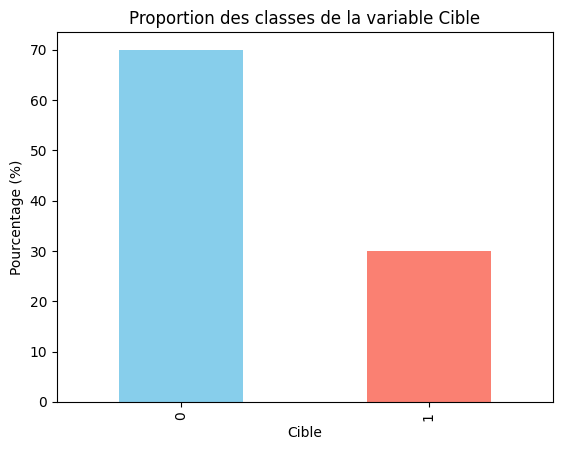

In [48]:
# Représentation variable Cible 
prop = df["Cible"].value_counts(normalize=True) * 100
prop.plot(kind="bar", color=["skyblue", "salmon"])
plt.title("Proportion des classes de la variable Cible")
plt.xlabel("Cible")
plt.ylabel("Pourcentage (%)")
plt.show()
# 70% de 0, et 30% de 1

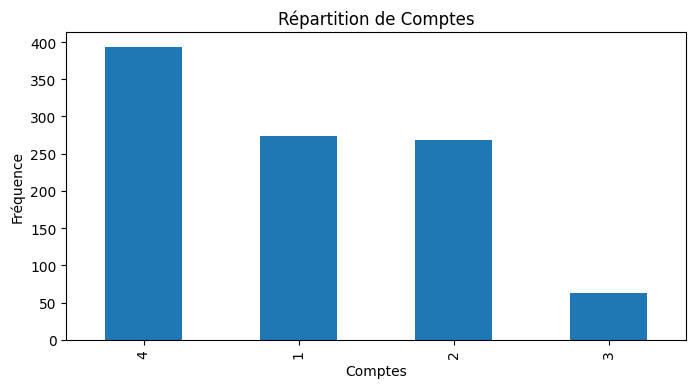

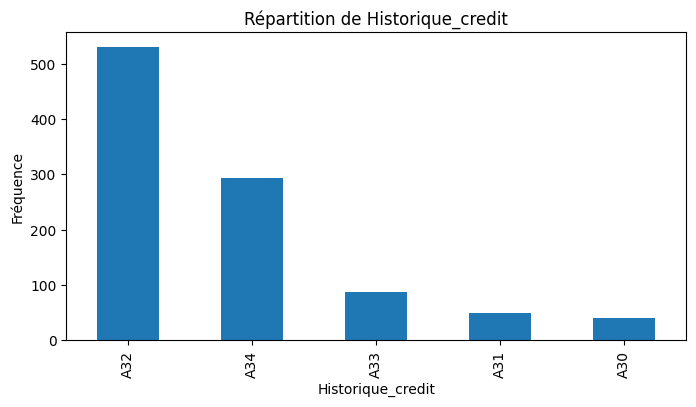

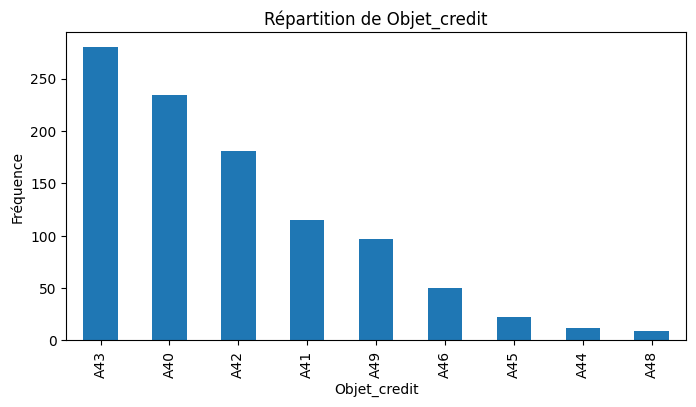

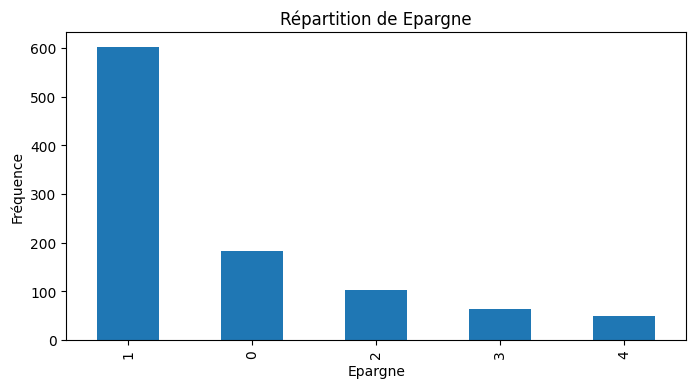

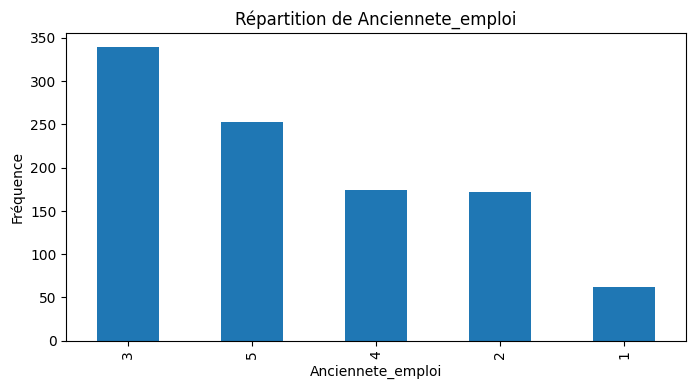

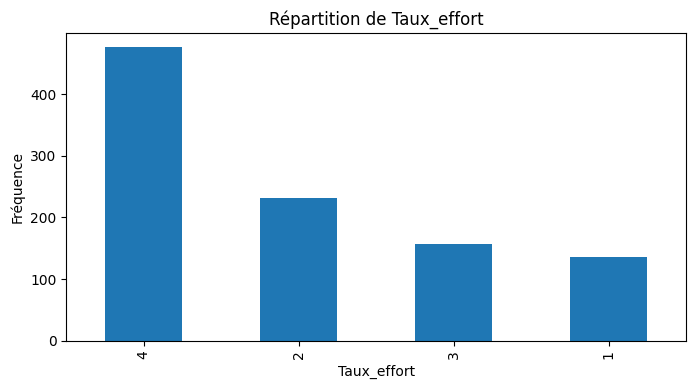

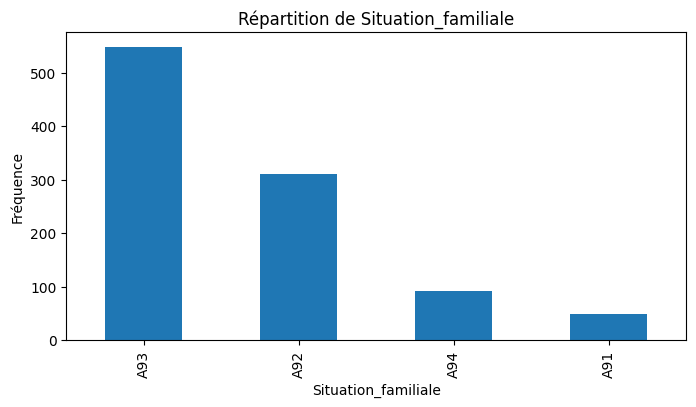

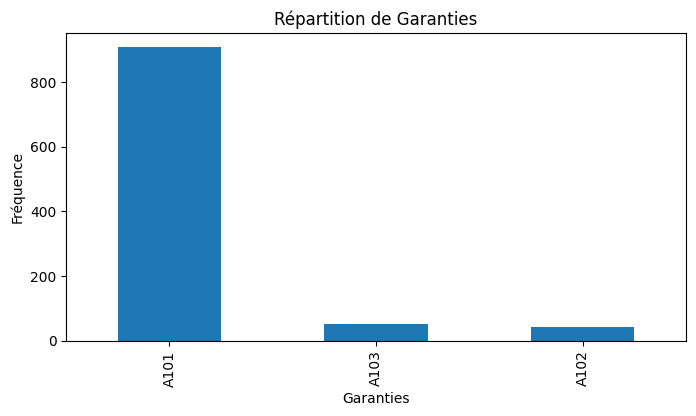

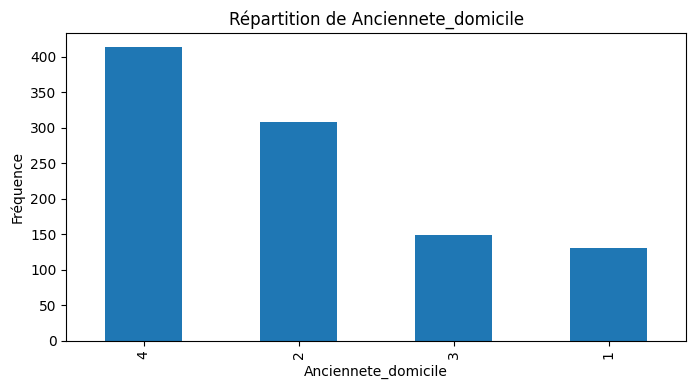

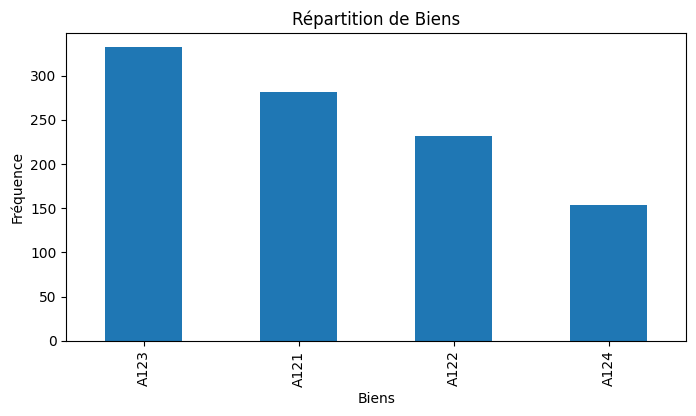

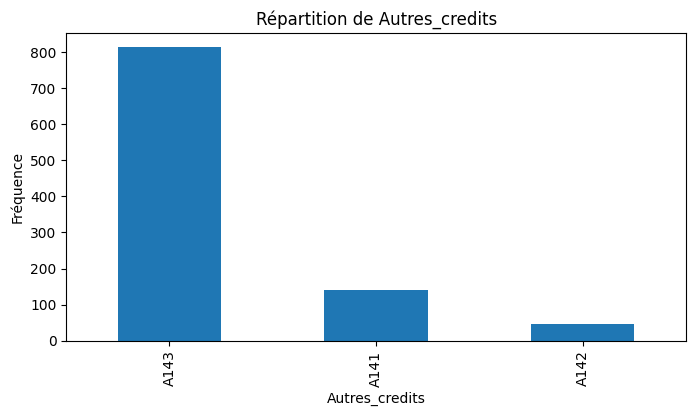

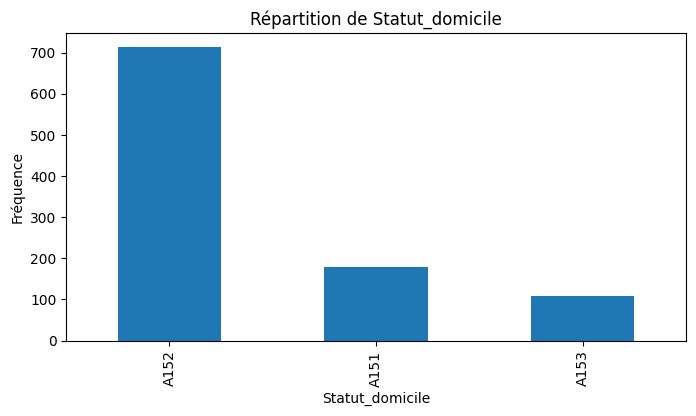

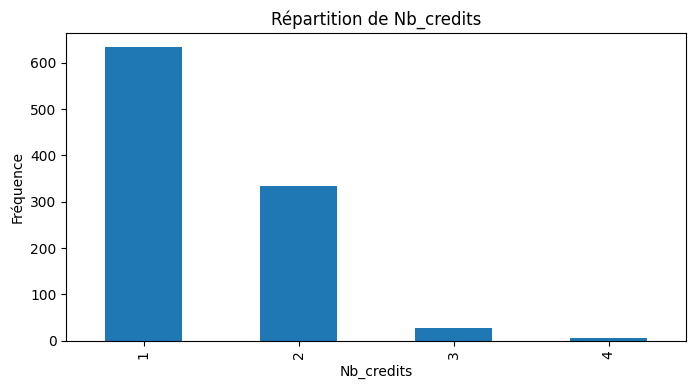

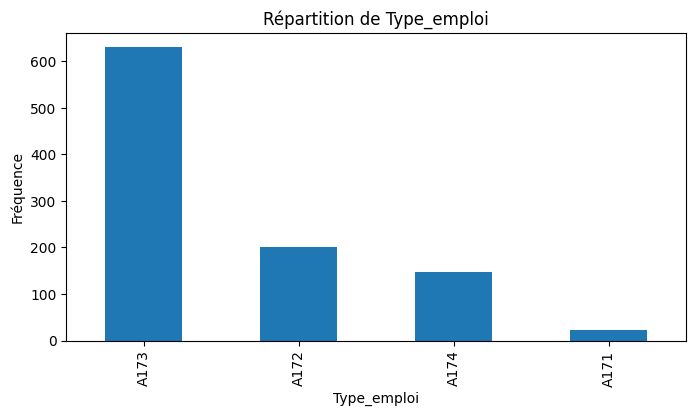

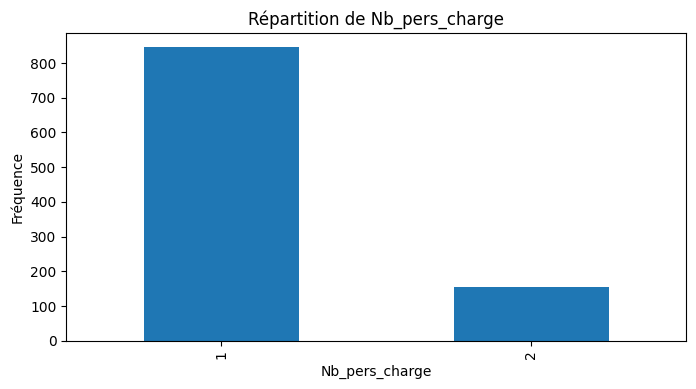

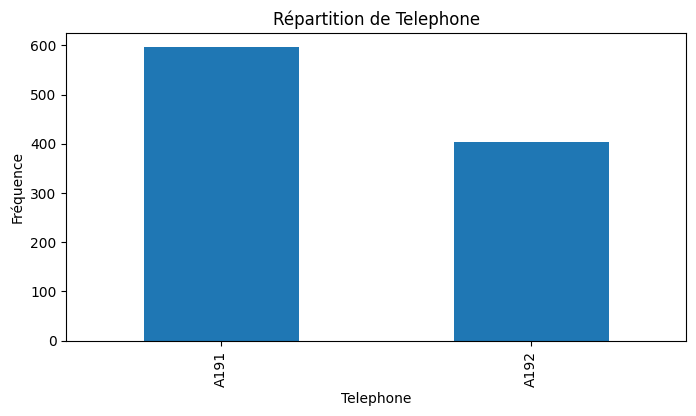

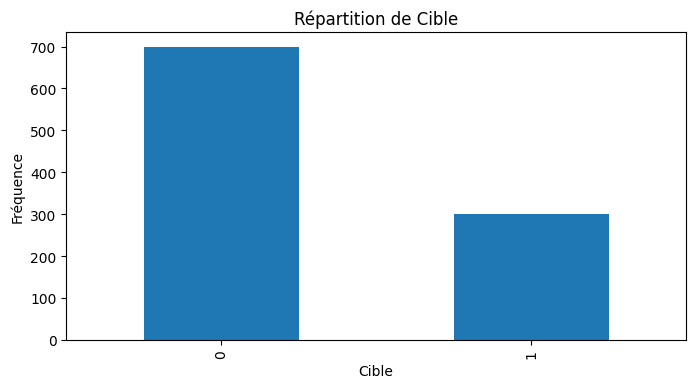

In [ ]:
# Barplot
for col in var_cat.columns:
    plt.figure(figsize=(8, 4))
    var_cat[col].value_counts().plot(kind="bar")
    plt.title(f"Répartition de {col}")
    plt.xlabel(col)
    plt.ylabel("Fréquence")
    plt.show()
# Certaines distributions sont inégales, comme par exemple dans Garanties, 
# où la majorité des observations sont concentrées dans la catégorie 'A101'.

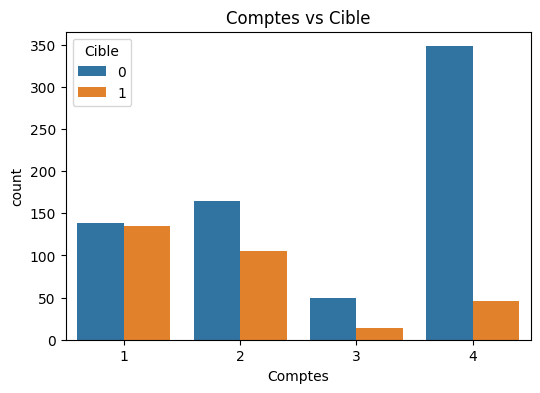

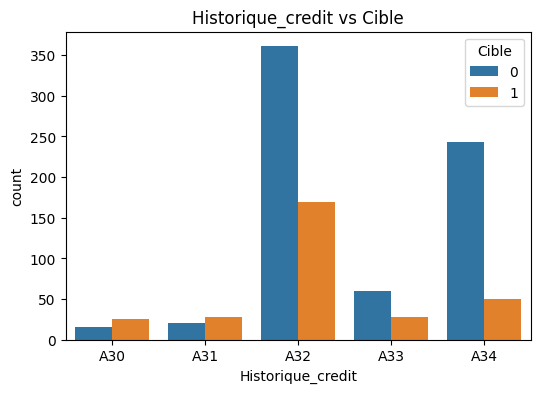

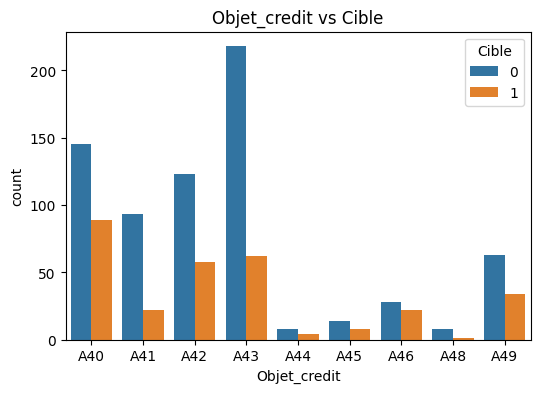

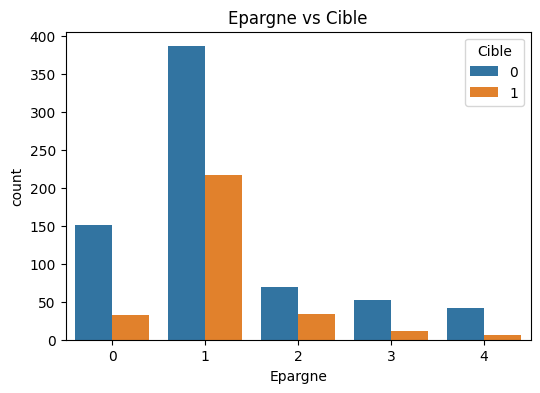

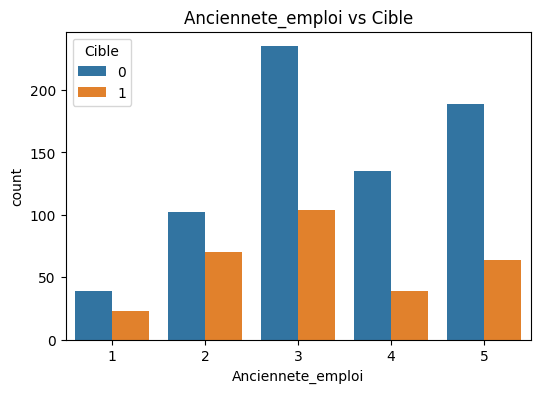

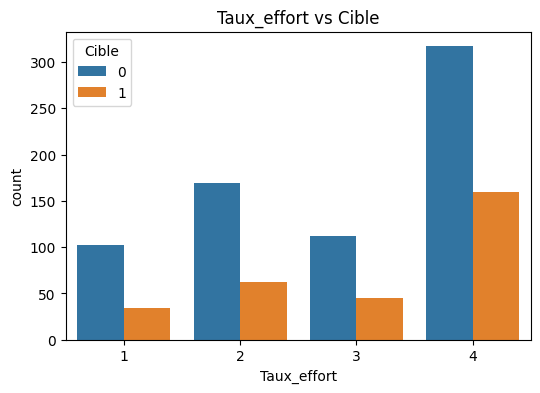

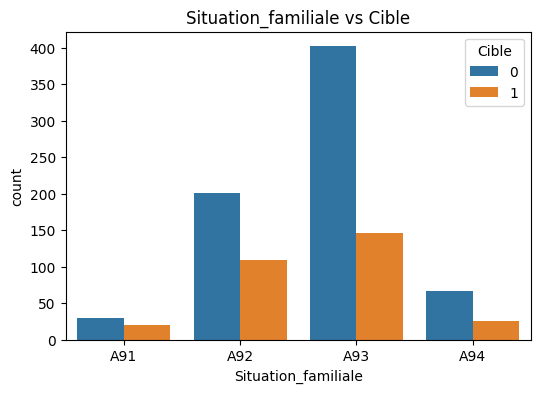

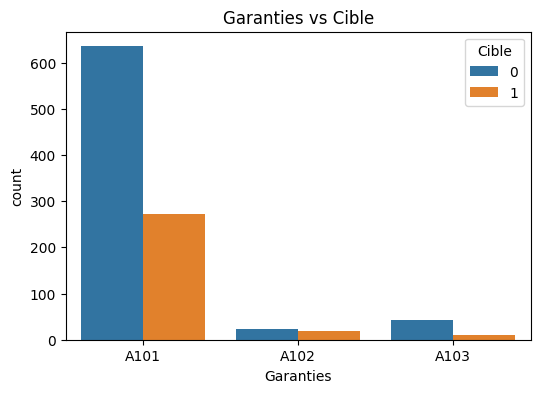

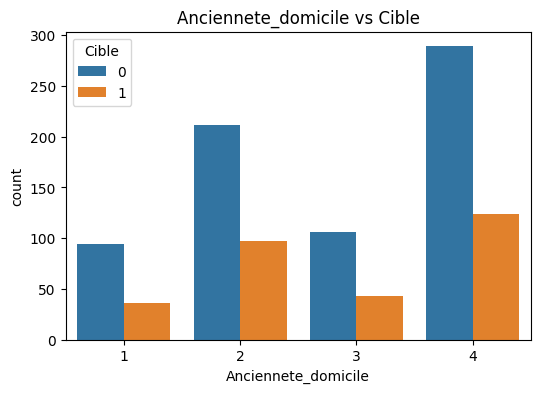

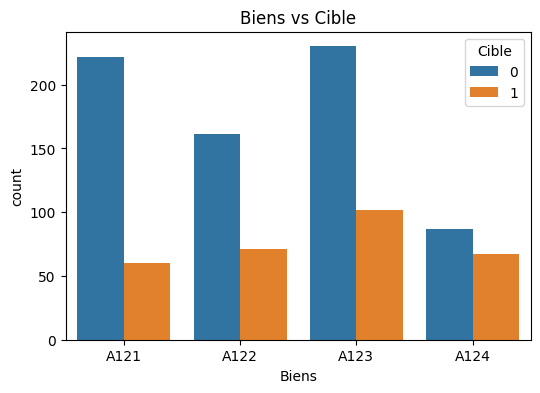

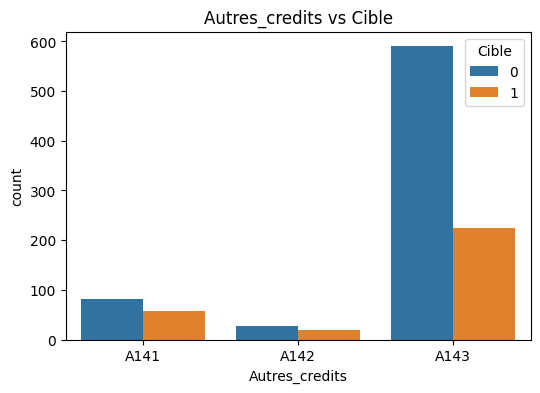

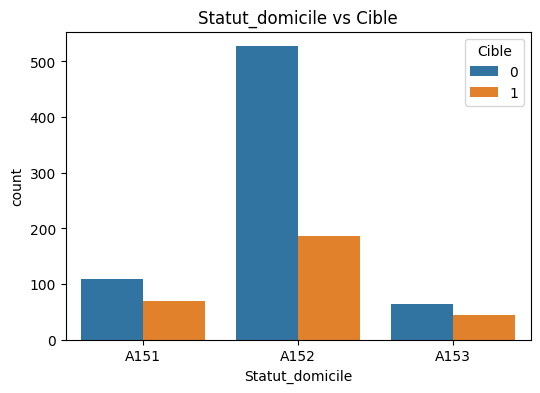

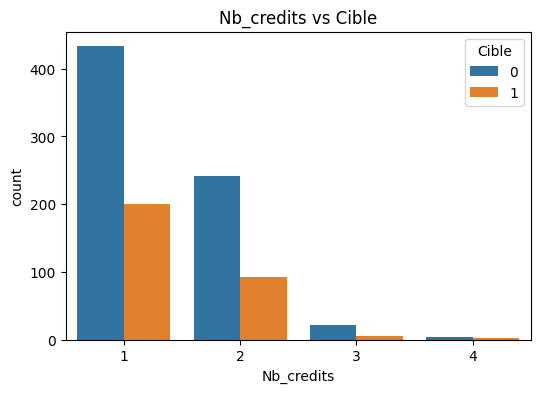

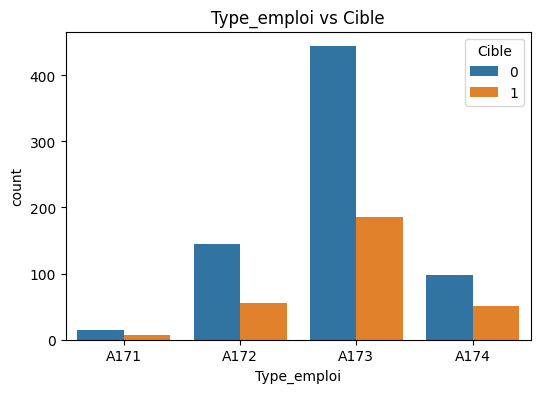

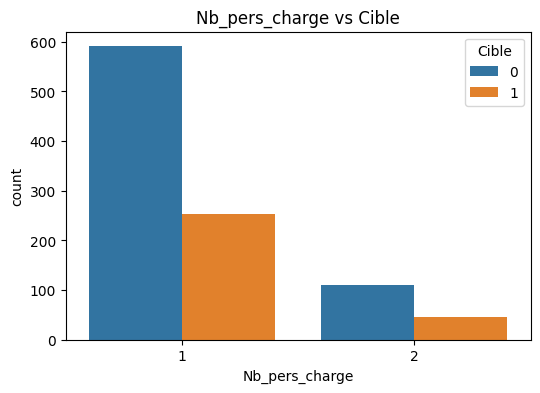

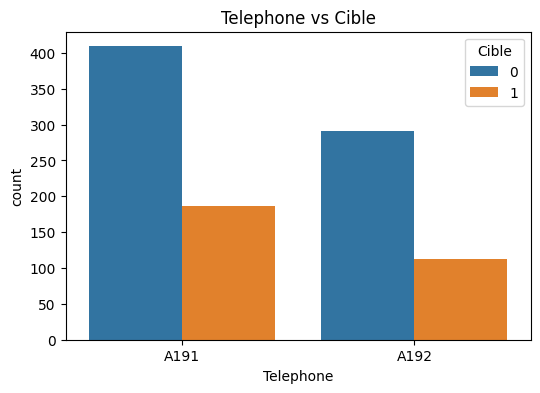

In [50]:
# Statistiques descriptives - Multivariées
# Par rapport à la variable Cible (en enlevant les variables continues numériques)
# Barplots croisés
for col in df.drop(
    columns=["Cible", "Cle", "Montant_credit", "Duree_credit", "Age"]
).columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, hue="Cible", data=df)
    plt.title(f"{col} vs Cible")
    plt.show()

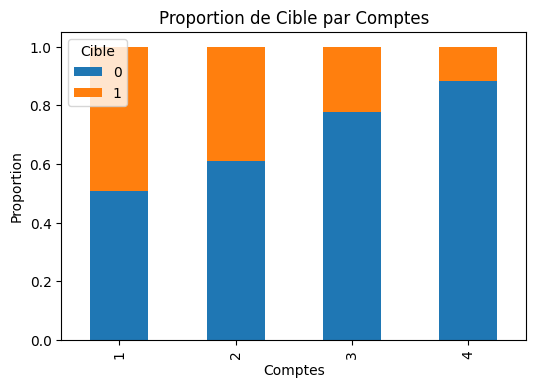

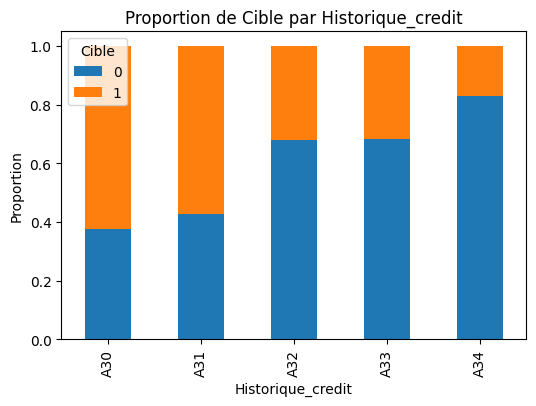

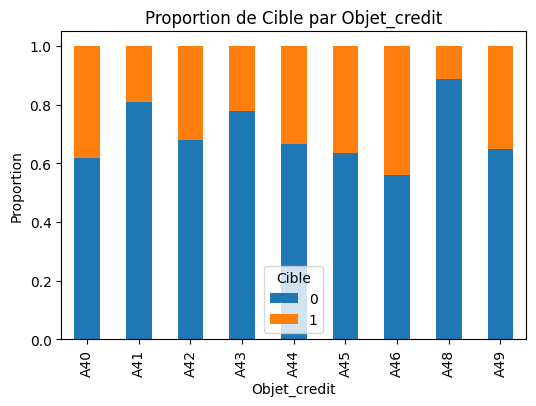

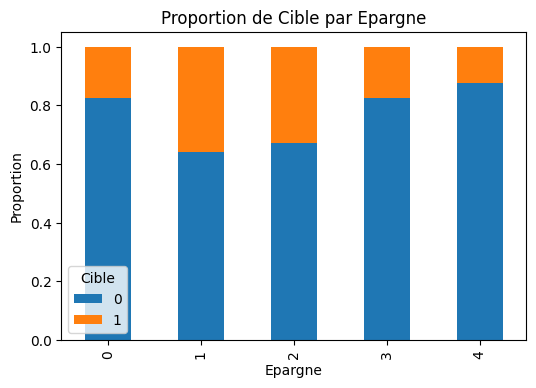

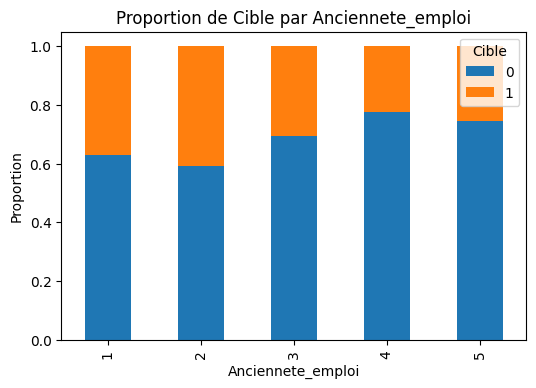

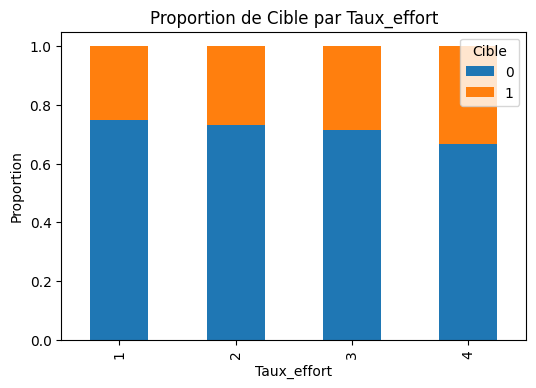

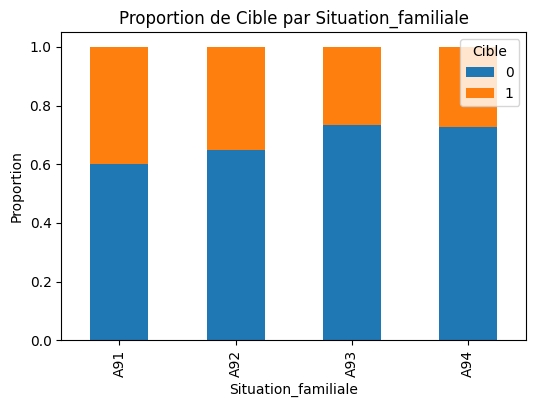

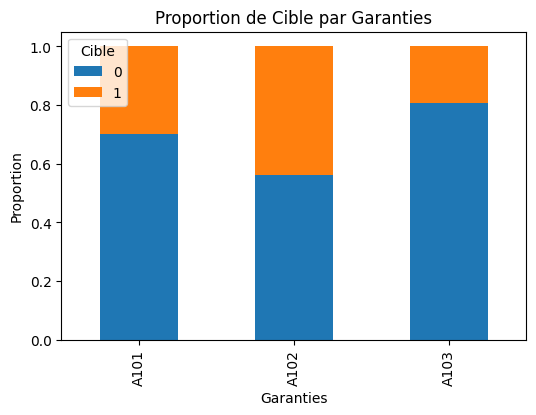

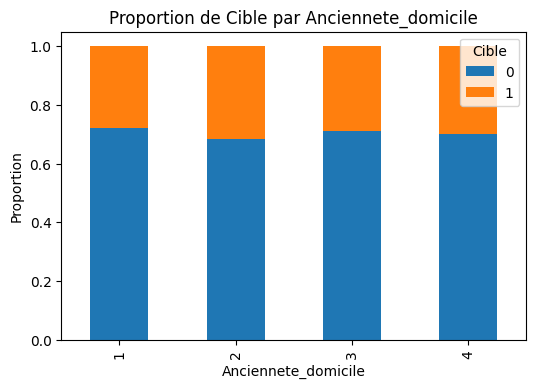

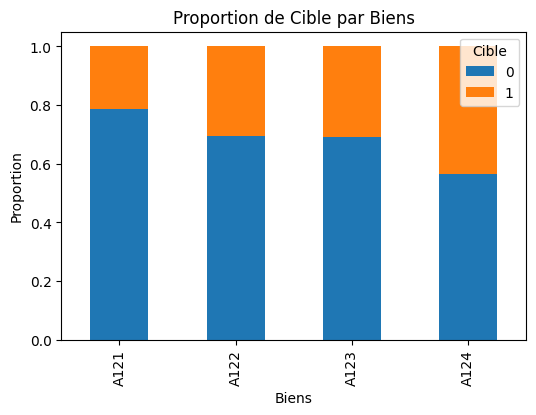

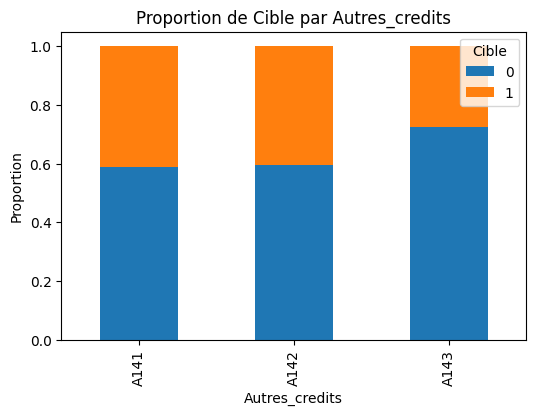

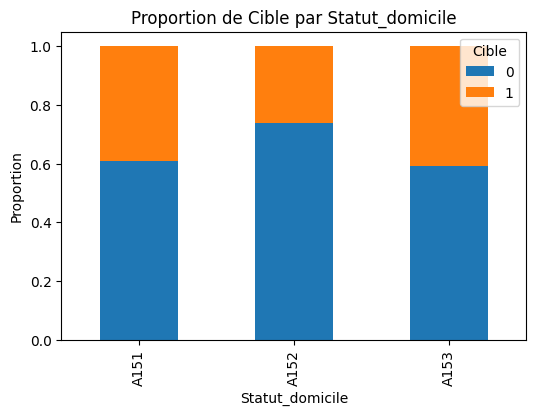

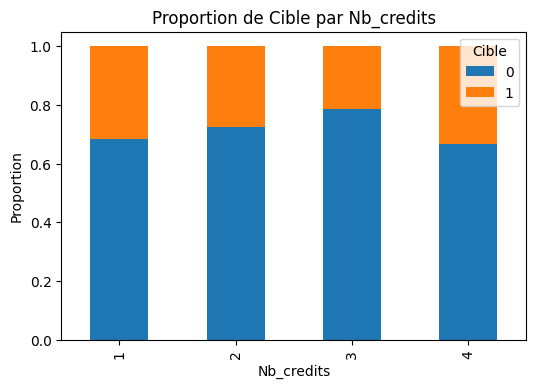

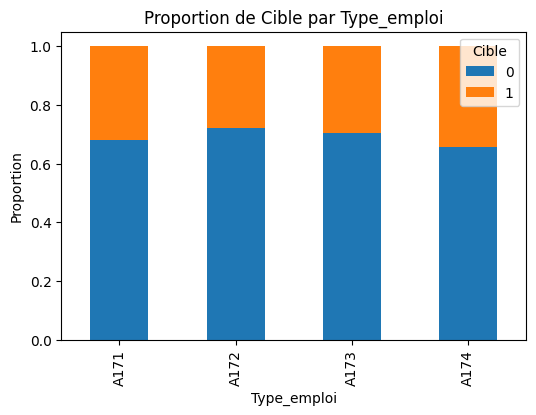

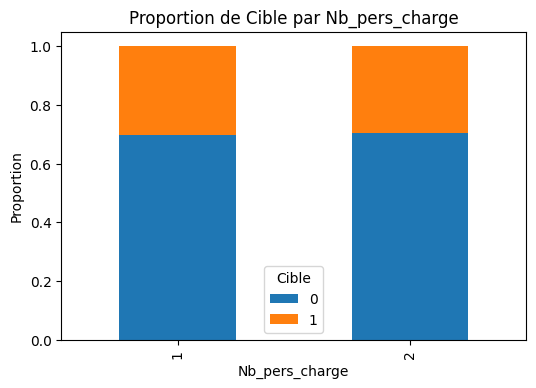

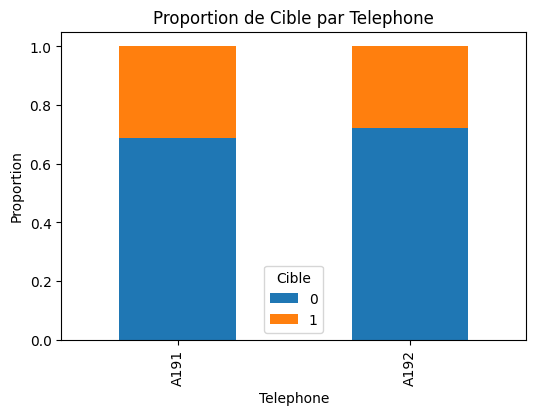

In [51]:
# Histogrammes empilés
for col in df.drop(
    columns=["Cible", "Cle", "Montant_credit", "Duree_credit", "Age"]
).columns:
    cross_tab = pd.crosstab(df[col], df["Cible"], normalize="index")
    cross_tab.plot(kind="bar", stacked=True, figsize=(6, 4))
    plt.title(f"Proportion de Cible par {col}")
    plt.ylabel("Proportion")
    plt.show()

## --- Corrélations ---

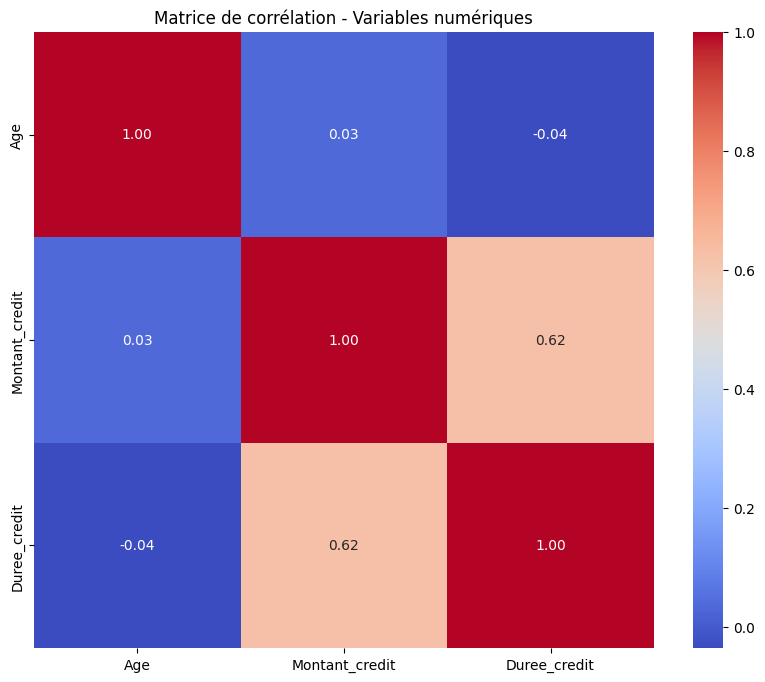

In [52]:
# Pearson
plt.figure(figsize=(10, 8))
corr_matrix = var_num.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation - Variables numériques")
plt.show()
# Corrélation de 0.62 entre Montant_credit et Duree_credit

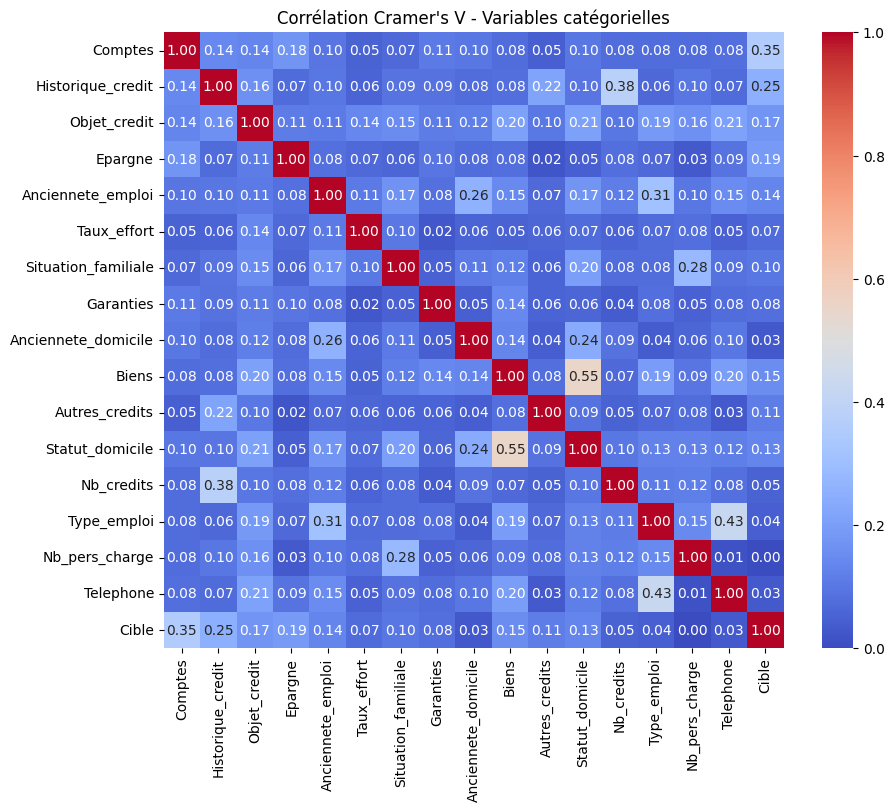

In [ ]:
# Khi2 et CramersV
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

cat_cols = var_cat.columns
cramers = pd.DataFrame(
    np.zeros((len(cat_cols), len(cat_cols))), index=cat_cols, columns=cat_cols
)
for col1 in cat_cols:
    for col2 in cat_cols:
        cramers.loc[col1, col2] = cramers_v(var_cat[col1], var_cat[col2])
plt.figure(figsize=(10, 8))
sns.heatmap(cramers, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Corrélation Cramer's V - Variables catégorielles")
plt.show()
# Corrélation de 0.55 entre Statut_domicile et Biens
# Corrélation de 0.43 entre Type_emploi et Telephone

## --- Création de variables croisées --- 

In [6]:
# Pour les variables fortement corrélées
# Intéraction numérique : Montant_credit et Duree_credit
df["interaction_montant_duree"] = df["Montant_credit"] * df["Duree_credit"]
print(list(df.columns))
var_num = var_num.copy()
var_num["interaction_montant_duree"] = df["interaction_montant_duree"]

['Cle', 'Comptes', 'Duree_credit', 'Historique_credit', 'Objet_credit', 'Montant_credit', 'Epargne', 'Anciennete_emploi', 'Taux_effort', 'Situation_familiale', 'Garanties', 'Anciennete_domicile', 'Biens', 'Age', 'Autres_credits', 'Statut_domicile', 'Nb_credits', 'Type_emploi', 'Nb_pers_charge', 'Telephone', 'Cible', 'interaction_montant_duree']


## --- Fine classing et coarse classing ---

In [ ]:
# Fine classing à faire que sur les variables continues

# Obj_credit plus de 5 catégories (9)
# => on fais coarse classing UNIQUEMENT sur cette variable catégorielle

In [7]:
# Séparation Train et Test
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['Cle']), # on enleve Cle car inutile, en enlève pas Cible car on en a besoin après
    df['Cible'], # Cible = variable target donc correspond au y
    test_size=0.2, # 20% de test, 80% de train
    random_state=42
)

In [8]:
# Fine et coarse classing
n_bins = 10       # Nombre de bacs pour fine classing
threshold = 0.15  # Seuil de fusion pour coarse classing
# Dictionnaire pour stocker les résultats
woe_iv_results = {}

def woe_iv(data, feature, target):
    tmp = data.groupby(feature, observed=False)[target].agg(['count', 'sum'])
    tmp.columns = ['total', 'bad']
    tmp['good'] = tmp['total'] - tmp['bad']
    total_good = tmp['good'].sum()
    total_bad = tmp['bad'].sum()
    tmp['pct_good'] = tmp['good'] / total_good
    tmp['pct_bad'] = tmp['bad'] / total_bad
    tmp['WOE'] = np.log((tmp['pct_good'] + 1e-10) / (tmp['pct_bad'] + 1e-10))
    tmp['IV'] = (tmp['pct_good'] - tmp['pct_bad']) * tmp['WOE']

    return tmp, tmp['IV'].sum()

# Boucle sur chaque variable numérique
for var in var_num:
    print(f"\n--- Traitement de {var} ---")
    
    # 1. Fine classing
    bin_fine_col = f"{var}_bin_fine"
    X_train[bin_fine_col] = pd.qcut(X_train[var], q=n_bins, duplicates='drop')
    # 2. Calcul WOE/IV sur bacs fins
    woe_table_fine, iv_fine = woe_iv(X_train, bin_fine_col, "Cible")
    print(f"IV fin ({var}) = {iv_fine:.4f}")
    print(woe_table_fine)
    # 3. Coarse classing : fusion des bacs proches selon WOE
    woe_table_fine = woe_table_fine.sort_values("WOE").reset_index()
    merge_group = 0
    groups = []
    for pos, row in woe_table_fine.iterrows():
        if pos == 0:
            merge_group += 1
        else:
            prev_woe = woe_table_fine.loc[pos-1, "WOE"]
            # Fusion si différence WOE > seuil
            if abs(row["WOE"] - prev_woe) > threshold:
                merge_group += 1
        groups.append(merge_group)
    woe_table_fine["merge_group"] = groups
    mapping = dict(zip(woe_table_fine[bin_fine_col], woe_table_fine["merge_group"]))
    bin_coarse_col = f"{var}_bin_coarse"
    X_train[bin_coarse_col] = X_train[bin_fine_col].map(mapping)
    # 4. WOE/IV sur bacs grossiers
    woe_table_coarse, iv_coarse = woe_iv(X_train, bin_coarse_col, "Cible")
    print(f"IV coarse ({var}) = {iv_coarse:.4f}")
    print(woe_table_coarse)
    # 5. Stocker les résultats
    woe_iv_results[var] = {
        "fine": (woe_table_fine, iv_fine),
        "coarse": (woe_table_coarse, iv_coarse)
    }
    woe_iv_results[var]["mapping"] = mapping

# Aucune classe n'est inférieure à 5% en terme de représentativité du jeu de données (X_train)

# Variable catégorielle : Objet_Credit
# Problème dans le code - vu qu'il y a déjà des catégories natives pour cette variable, on va la garder comme ça 


--- Traitement de Age ---
IV fin (Age) = 0.1352
                total  bad  good  pct_good   pct_bad       WOE        IV
Age_bin_fine                                                            
(18.999, 23.0]     84   38    46  0.082290  0.157676 -0.650297  0.049024
(23.0, 26.0]      107   41    66  0.118068  0.170124 -0.365270  0.019015
(26.0, 28.0]       79   25    54  0.096601  0.103734 -0.071244  0.000508
(28.0, 30.0]       66   23    43  0.076923  0.095436 -0.215647  0.003992
(30.0, 33.0]       74   23    51  0.091234  0.095436 -0.045021  0.000189
(33.0, 36.0]       89   19    70  0.125224  0.078838  0.462704  0.021463
(36.0, 39.3]       61   17    44  0.078712  0.070539  0.109624  0.000896
(39.3, 45.0]       88   21    67  0.119857  0.087137  0.318818  0.010432
(45.0, 52.0]       77   16    61  0.109123  0.066390  0.496933  0.021236
(52.0, 75.0]       75   18    57  0.101968  0.074689  0.311327  0.008493
IV coarse (Age) = 0.1248
                total  bad  good  pct_good   pct_b

In [9]:
# Ajout des variables coarse à X_test en utilisant les mêmes bins
# Stocker le mapping utilisé pour X_train pour pouvoir l'appliquer à X_test
woe_iv_results[var]["mapping"] = mapping

# Appliquer les mappings coarse du train vers le test
for var in var_num:
    bin_fine_col = f"{var}_bin_fine"
    bin_coarse_col = f"{var}_bin_coarse"
    # --- 1. reproduire le qcut train sur le test ---
    # Récupérer les bords d'intervalles de X_train
    train_bins = X_train[bin_fine_col].cat.categories
    # Convertir catégorie string → interval
    intervals = [pd.Interval(left=i.left, right=i.right, closed=i.closed) for i in train_bins]
    # Binning du test selon les mêmes intervalles
    X_test[bin_fine_col] = pd.cut(X_test[var], bins=[i.left for i in intervals] + [intervals[-1].right],
                                  include_lowest=True)
    # --- 2. appliquer le mapping coarse ---
    mapping = woe_iv_results[var]["mapping"]
    X_test[bin_coarse_col] = X_test[bin_fine_col].map(mapping)
    # Remplir les éventuelles valeurs manquantes si un intervalle est absent du test
    X_test[bin_coarse_col] = X_test[bin_coarse_col].fillna(0)

print(X_test.head())

     Comptes  Duree_credit Historique_credit Objet_credit  Montant_credit  \
521        1            18               A32          A43            3190   
737        1            18               A32          A40            4380   
740        1            24               A31          A40            2325   
660        3            12               A32          A43            1297   
411        4            33               A34          A41            7253   

     Epargne  Anciennete_emploi  Taux_effort Situation_familiale Garanties  \
521        1                  3            2                 A92      A101   
737        2                  3            3                 A93      A101   
740        2                  4            2                 A93      A101   
660        1                  3            3                 A94      A101   
411        1                  4            3                 A93      A101   

     ...  Cible interaction_montant_duree                Age_bin_fin

In [10]:
def replace_with_coarse(df):
    """
    Remplace les variables originales par leurs versions coarse,
    et supprime les variables bin/bin_coarse.
    """
    coarse_vars = [col for col in df.columns if "coarse" in col.lower()]
    bin_vars = [col for col in df.columns if "bin" in col.lower()]
    bases_to_remove = []
    for coarse in coarse_vars:
        base_name = (
            coarse.replace("_coarse", "")
                  .replace("coarse_", "")
        )
        if base_name in df.columns:
            bases_to_remove.append(base_name)
    df_clean = df.drop(columns=bases_to_remove + bin_vars, errors="ignore")
    for col in coarse_vars:
        if col not in df_clean.columns:
            df_clean[col] = df[col]
    return df_clean

# Application à X_train et X_test
X_train_final = replace_with_coarse(X_train)
try:
    X_test_final = replace_with_coarse(X_test)
except:
    pass

print("Vérification variables X_train :", len(X_train_final.columns))
print("Vérification variables X_test :", len(X_test_final.columns))

# Suppression des variables originales
X_train_final = X_train_final.drop(columns=[
    "Montant_credit", 
    "Duree_credit", 
    "Age",
    "interaction_montant_duree"
])
print("Variables finales X_train:", X_train_final.columns.tolist())
X_test_final = X_test_final.drop(columns=[
    "Montant_credit", 
    "Duree_credit", 
    "Age",
    "interaction_montant_duree"
])
print("Variables finales X_test:", X_test_final.columns.tolist())

# Mise au format "category" des variables catégorielles
for col in X_train_final.select_dtypes('object').columns:
    X_train_final[col] = X_train_final[col].astype('category')
for col in X_test_final.select_dtypes('object').columns:
    X_test_final[col] = X_test_final[col].astype('category')
# Vérification
X_train_final.info()
X_test_final.info()
# Il y a bien les 21 bonnes variables à la fin pour chaque X

Vérification variables X_train : 25
Vérification variables X_test : 25
Variables finales X_train: ['Comptes', 'Historique_credit', 'Objet_credit', 'Epargne', 'Anciennete_emploi', 'Taux_effort', 'Situation_familiale', 'Garanties', 'Anciennete_domicile', 'Biens', 'Autres_credits', 'Statut_domicile', 'Nb_credits', 'Type_emploi', 'Nb_pers_charge', 'Telephone', 'Cible', 'Age_bin_coarse', 'Montant_credit_bin_coarse', 'Duree_credit_bin_coarse', 'interaction_montant_duree_bin_coarse']
Variables finales X_test: ['Comptes', 'Historique_credit', 'Objet_credit', 'Epargne', 'Anciennete_emploi', 'Taux_effort', 'Situation_familiale', 'Garanties', 'Anciennete_domicile', 'Biens', 'Autres_credits', 'Statut_domicile', 'Nb_credits', 'Type_emploi', 'Nb_pers_charge', 'Telephone', 'Cible', 'Age_bin_coarse', 'Montant_credit_bin_coarse', 'Duree_credit_bin_coarse', 'interaction_montant_duree_bin_coarse']
<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 29 to 102
Data columns (total 21 columns):
 #   Co

In [11]:
# Test de stabilité des classes - X_train et X_test
def compute_psi(train, test, n_bins=10):
    """
    Calcule le Population Stability Index (PSI)
    entre la distribution de train et celle de test.
    """
    # mêmes bornes pour les deux jeux
    quantiles = np.linspace(0, 1, n_bins + 1)
    bins = np.unique(np.quantile(train, quantiles))
    train_counts, _ = np.histogram(train, bins=bins)
    test_counts, _ = np.histogram(test, bins=bins)
    train_perc = train_counts / len(train)
    test_perc = test_counts / len(test)
    psi = np.sum((train_perc - test_perc) * np.log((train_perc + 1e-10) / (test_perc + 1e-10)))

    return psi

psi_results = {}

for var in var_num:
    col = f"{var}_bin_coarse"

    psi = compute_psi(
        X_train[col].astype(float),
        X_test[col].astype(float)
    )

    psi_results[var] = psi
    print(f"PSI {var} = {psi:.4f}")

# Interprétation du PSI : 
# Age et interaction_montant_duree : modérément instables (0.1 < PSI < 0.25 (= très instable))
# Montant_credit et Duree_credit : stables (PSI < 0.1)
# Nous pouvons alors conserver ces classes.

PSI Age = 2.1811
PSI Montant_credit = 0.0504
PSI Duree_credit = 0.0722
PSI interaction_montant_duree = 0.1955


## --- Encodage des variables catégorielles texte (où valeurs = A...) ---

In [12]:
# On garde une copie de X_train et X_test non encodés pour le modèle catboost
X_train_cb = X_train_final.copy()
X_test_cb = X_test_final.copy()

# Encodage 
quali_train = [
    col for col in X_train_final.columns
    if X_train_final[col].dtype == "category"
    and X_train_final[col].cat.categories.dtype == "object"
]
quali_test = [
    col for col in X_test_final.columns
    if X_test[col].dtype == "category"
    and X_test[col].cat.categories.dtype == "object"
]

# Vérification si les variables considérées sont les mêmes dans train et test
assert set(quali_train) == set(quali_test), "Variables quali différentes entre train et test !"

# Dictionnaire pour stocker les encodeurs
encoders = {}

# Train (fit + transform)
for var in quali_train:
    le = LabelEncoder()
    # Entraînement sur X_train uniquement
    X_train_final[var] = le.fit_transform(X_train_final[var])
    # Sauvegarde de l'encodeur
    encoders[var] = le

# Test (transform seulement)
for var in quali_test:
    le = encoders[var]
    # Gestion des catégories jamais vues dans le train
    X_test_final[var] = X_test_final[var].apply(
        lambda x: le.transform([x])[0] #if x in le.classes_ else -1
    )

print(X_train_final.head())
print(X_test_final.head())

     Comptes  Historique_credit  Objet_credit  Epargne  Anciennete_emploi  \
29         1                  3             8        1                  5   
535        3                  4             6        1                  2   
695        4                  2             1        3                  3   
557        4                  0             0        0                  3   
836        4                  2             3        0                  3   

     Taux_effort  Situation_familiale  Garanties  Anciennete_domicile  Biens  \
29             3                    2          0                    4      3   
535            2                    0          0                    1      2   
695            2                    2          0                    4      1   
557            1                    1          0                    4      1   
836            4                    1          0                    2      2   

     ...  Statut_domicile  Nb_credits  Type_emploi  Nb_p

In [13]:
# Fonction Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))
# Liste des variables catégorielles explicatives (sans Cle)
cat_cols = var_cat.columns.tolist()
if "Cle" in cat_cols:
    cat_cols.remove("Cle")
# Calcul Cramér's V avec la variable cible
cramers_target = {}
for col in cat_cols:
    cramers_target[col] = cramers_v(var_cat[col], df["Cible"])

cramers_df = pd.DataFrame.from_dict(cramers_target, orient='index', columns=['CramersV'])
# Filtrer les variables avec Cramér's V > 0.10
variables_pertinentes = cramers_df[cramers_df['CramersV'] > 0.10].sort_values(by='CramersV', ascending=False)
print("Variables catégorielles corrélées à la cible (Cramér's V > 0.10) :")
print(variables_pertinentes)
# Sachant que Statut_domicile et Biens étaient très corrélés, on va conserver Biens et non Statut_domicile, car plus liée avec Cible
# Nous conserverons toutes les variables numériques étant donné qu'il n'y en a pas beaucoup et qu'elles semblent très pertinentes économiquement
# Les variables utilisées pour l'analyse seront donc : 
# Catégorielles : Comptes, Historique_credit, Epargne, Objet_credit, Biens, Anciennete_emploi, Autres_credits 
# Numériques : Age, interaction_montant_duree

Variables catégorielles corrélées à la cible (Cramér's V > 0.10) :
                   CramersV
Cible              0.997619
Comptes            0.351740
Historique_credit  0.248378
Epargne            0.189997
Objet_credit       0.173540
Biens              0.154012
Anciennete_emploi  0.135530
Statut_domicile    0.134907
Autres_credits     0.113310


## --- Modèles ---

In [14]:
# Train et test 
# Exclusion de la variable Cible de X
X_train_final = X_train_final.drop(columns=['Cible'])
X_test_final = X_test_final.drop(columns=['Cible'])
# Pour catboost : 
X_train_cb = X_train_cb.drop(columns=['Cible'])
X_test_cb = X_test_cb.drop(columns=['Cible'])

In [15]:
# 1. Modèle Logistique
X_train_sm = sm.add_constant(X_train_final)
logit_model = sm.Logit(y_train, X_train_sm).fit(disp=0)
X_test_sm = sm.add_constant(X_test_final, has_constant='add')
y_pred_logit = logit_model.predict(X_test_sm)
auc_logit = roc_auc_score(y_test, y_pred_logit)

In [16]:
# 2. Modèle Probit
probit_model = sm.Probit(y_train, X_train_sm).fit(disp=0)
y_pred_probit = probit_model.predict(X_test_sm)
auc_probit = roc_auc_score(y_test, y_pred_probit)

In [ ]:
# 3. CatBoost
# (prends environ 3 minutes à tourner)
# Utilisation de X_train et X_test non encodés
cat_cols = X_train_cb.select_dtypes(include=["object", "category"]).columns.tolist()
cat_features_idx = [X_train_cb.columns.get_loc(c) for c in cat_cols]

# Param grid
cat_params = {
    "depth": [4, 6, 8],          
    "learning_rate": [0.05], 
    "iterations": [400, 500, 600], 
}

cat_model = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    verbose=0,
    cat_features=cat_features_idx,
    early_stopping_rounds=50  # permet d'arrêter automatiquement le grid_search si l'AUC ne s'améliore plus
)

# GridSearch interne CatBoost 
cat_model.grid_search(
    cat_params,
    X=X_train_cb,
    y=y_train,
    plot=False
)
y_pred_catboost = cat_model.predict_proba(X_test_cb)[:, 1]
auc_cat = roc_auc_score(y_test, y_pred_catboost)


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7605597527
bestIteration = 7

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.7605598	best: 0.7605598 (0)	total: 3.64s	remaining: 29.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7605597527
bestIteration = 7

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.7605598	best: 0.7605598 (0)	total: 6.83s	remaining: 23.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7605597527
bestIteration = 7

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.7605598	best: 0.7605598 (0)	total: 9.87s	remaining: 19.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7798763736
bestIteration = 10

In [ ]:
# 4. Forêt Aléatoire
# (Prends environ 30 secondes à tourner)
param_grid_rf = {
    "n_estimators": [300, 500, 800],
    "max_depth": [None, 10, 20, 30],
    "max_features": ["sqrt", "log2"],
}

rf = RandomForestClassifier(random_state=42)

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_rf.fit(X_train_final, y_train)
print("Meilleurs paramètres RF :", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict_proba(X_test_final)[:,1]
auc_rf = roc_auc_score(y_test, y_pred_rf)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Meilleurs paramètres RF : {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 300}


## --- Performance et comparaison des modèles ---

In [ ]:
# Importances des variables, Indice de Gini, AUC, ROC, F-score, F-stat, Recall

# Fonction pour calculer toutes les métriques
def compute_metrics(y_true, y_pred_proba, threshold=0.5):
    y_pred_class = (y_pred_proba >= threshold).astype(int)

    auc = roc_auc_score(y_true, y_pred_proba)
    gini = 2 * auc - 1
    precision = precision_score(y_true, y_pred_class)
    recall = recall_score(y_true, y_pred_class)
    f1 = f1_score(y_true, y_pred_class)

    return {
        "AUC": auc,
        "Gini": gini,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    }

# Calcul des métriques pour chaque modèle
results = {
    "Logit": compute_metrics(y_test, y_pred_logit),
    "Probit": compute_metrics(y_test, y_pred_probit),
    "CatBoost": compute_metrics(y_test, y_pred_catboost),
    "Random Forest": compute_metrics(y_test, y_pred_rf),
}

results_df = pd.DataFrame(results).T
print("\n=== Comparaison des modèles ===\n")
print(results_df)

# Interprétation des résultats : 
# 1) AUC et Gini : 
# Random Forest est le meilleur modèle (AUC = 0.803, Gini = 0.606) => discrimine le mieux les bons et mauvais payeurs.
# CatBoost arrive en second (AUC = 0.69).
# Logit et Probit sont équivalents (AUC d'environ 0.755) : modèles les plus simples, donc moins performants mais plus interprétables.

# 2) Precision, Recall, F1-score :
# Logit et Probit ont le meilleur compromis Recall/F1-score : détectent mieux les mauvais payeurs (Recall = 0.66).
# CatBoost a une bonne précision (0.59) mais un recall plus faible (0.52) : identifie bien les défauts qu’il prédit, mais en manque beaucoup.
# Random Forest est équilibré (Precision = 0.61, Recall = 0.59) : Bon compromis entre détection du risque et stabilité.

# Conclusion performance
# Random Forest est le meilleur modèle global en termes de discrimination (AUC/Gini).
# Logit et Probit restent très bons pour maximiser la détection des défauts (Recall).
# CatBoost est entre les deux : bonne discrimination mais faible sensibilité.


=== Comparaison des modèles ===

                    AUC      Gini  Precision    Recall  F1-score
Logit          0.755139  0.510278   0.541667  0.661017  0.595420
Probit         0.756461  0.512922   0.541667  0.661017  0.595420
CatBoost       0.769684  0.539368   0.596154  0.525424  0.558559
Random Forest  0.803342  0.606683   0.614035  0.593220  0.603448


In [35]:
# Importance des variables (si applicable)
print("\n=== Importances des variables === \n")

# Logit : coefficients + p-values
logit_imp = pd.DataFrame({
    "variable": X_train_final.columns,
    "coef": logit_model.params[1:],  
    "p-value": logit_model.pvalues[1:]
}).sort_values(by="coef", key=abs, ascending=False)
print("\nLogit (coefficients) :")
print(logit_imp.head(10))

# Probit : coefficients aussi
probit_imp = pd.DataFrame({
    "variable": X_train_final.columns,
    "coef": probit_model.params[1:],
    "p-value": probit_model.pvalues[1:]
}).sort_values(by="coef", key=abs, ascending=False)
print("\nProbit (coefficients) :")
print(probit_imp.head(10))

# Random Forest
rf_imp = pd.DataFrame({
    "variable": X_train_final.columns,
    "importance": best_rf.feature_importances_
}).sort_values(by="importance", ascending=False)
print("\nRandom Forest (feature importance) :")
print(rf_imp.head(10))

# CatBoost
cat_imp = pd.DataFrame({
    "variable": X_train_cb.columns,
    "importance": cat_model.get_feature_importance()
}).sort_values(by="importance", ascending=False)
print("\nCatBoost (feature importance) :")
print(cat_imp.head(10))

# Tous les modèles convergent sur les mêmes variables clés permettant de prédire la Cible :
# Les 3 variables les plus importantes parmi les modèles sont : Comptes, Historique_credit, Objet_credit, Montant_credit, Garanties

# Random Forest et CatBoost identifient davantage de variables liées :
# à la stabilité financière et personnelle, et à la structure du crédit.

# Logit et Probit sont plus simples mais confirment néanmoins des relations fondamentales :
# plus de crédits augmente le risque,
# meilleur historique/plus d’actifs diminue le risque


=== Importances des variables === 


Logit (coefficients) :
                                            variable      coef       p-value
Comptes                                      Comptes -0.572574  1.130168e-13
Montant_credit_bin_coarse  Montant_credit_bin_coarse -0.567525  9.079288e-02
Historique_credit                  Historique_credit -0.398336  2.010074e-05
Garanties                                  Garanties -0.360636  5.734283e-02
Nb_credits                                Nb_credits  0.346212  5.136110e-02
Autres_credits                        Autres_credits -0.298006  1.634828e-02
Telephone                                  Telephone -0.268601  1.945498e-01
Situation_familiale              Situation_familiale -0.260871  4.844847e-02
Age_bin_coarse                        Age_bin_coarse -0.249267  7.470284e-03
Taux_effort                              Taux_effort  0.240704  5.740835e-03

Probit (coefficients) :
                                            variable      coef     

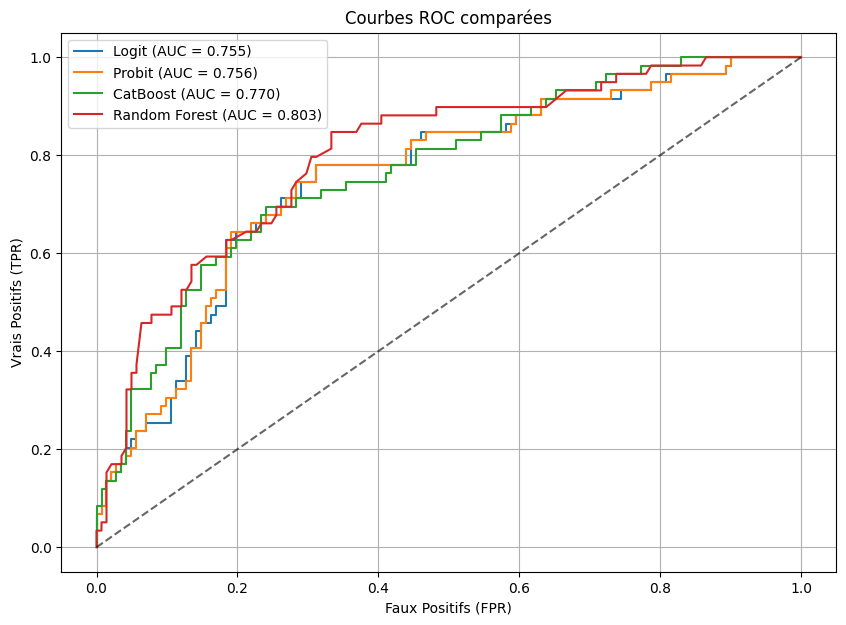

In [36]:
# Comparaison des courbes ROC

plt.figure(figsize=(10, 7))

models = {
    "Logit": y_pred_logit,
    "Probit": y_pred_probit,
    "CatBoost": y_pred_catboost,
    "Random Forest": y_pred_rf,
}

for name, pred in models.items():
    fpr, tpr, _ = roc_curve(y_test, pred)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, pred):.3f})")

plt.plot([0, 1], [0, 1], "k--", alpha=0.6)
plt.title("Courbes ROC comparées")
plt.xlabel("Faux Positifs (FPR)")
plt.ylabel("Vrais Positifs (TPR)")
plt.legend()
plt.grid(True)
plt.show()

# La courbe ROC du modèle Random Forest est globalement la plus haute, confirmant que c'est le modèle discriminant le mieux.

## --- Construction du score et des seuils de prédictions - Meilleur modèle (Random Forest) ---

In [ ]:
# 1. Probabilités de défaut (déjà calculées)

# 2. Construction d’un score (score = 1 - probability)
df_scores = pd.DataFrame({
    "y_true": y_test,
    "proba_defaut": y_pred_rf
})
# Score entre 0 et 1000
df_scores["score"] = (1 - df_scores["proba_defaut"]) * 1000

# 3. Seuil optimal ROC (Youden J)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)
youden_index = tpr - fpr
best_threshold_roc = thresholds[np.argmax(youden_index)]
# 4. Seuil optimal F1-score 
best_f1 = 0
best_threshold_f1 = 0
for thr in np.linspace(0, 1, 200):
    y_pred_temp = (y_pred_rf >= thr).astype(int)
    f1 = f1_score(y_test, y_pred_temp)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold_f1 = thr
# 5. Seuil métier : accepter max 5% de défaut
# Tri par probabilité croissante (meilleurs clients en premier)
df_sorted = df_scores.sort_values("proba_defaut")
# Proportion cumulative de défauts
df_sorted["cumulative_bad_rate"] = df_sorted["y_true"].expanding().mean()
# Seuil métier : 5% de défaut dans les acceptés
risk_limit = 0.05
try:
    threshold_business = df_sorted[
        df_sorted["cumulative_bad_rate"] <= risk_limit
    ]["proba_defaut"].max()
    if pd.isna(threshold_business):
        threshold_business = df_sorted["proba_defaut"].min()
except:
    threshold_business = df_sorted["proba_defaut"].median()

# 6. Classes de risque simples
def classify_risk(p):
    if p < 0.05:
        return "Low Risk"
    elif p < 0.12:
        return "Medium Risk"
    else:
        return "High Risk"

df_scores["risk_class"] = df_scores["proba_defaut"].apply(classify_risk)

# 7. Résumé final des seuils obtenus
print("\n=== Seuils de décision === \n")
print(f"Seuil ROC optimal (Youden)       : {best_threshold_roc:.4f}")
print(f"Seuil F1 optimal                 : {best_threshold_f1:.4f}")
print(f"Seuil métier (5% bad rate)       : {threshold_business:.4f}")

# Interprétation des seuils
# Seuil ROC optimal (Youden) = 0.3633 : 
# Maximise le compromis sensibilité - spécificité.
# Tout client ayant une proba >= 0.3633 serait classé “défaillant”.

# Seuil F1 optimal = 0.3618 :
# Proche du seuil ROC, équilibre précision et rappel.
# Permet de minimiser simultanément les faux positifs et les faux négatifs.

# Seuil métier (5% bad rate) = 0.1267
# N'accepte que les clients dont la probabilité de défaut est très faible (< 12,7%).
# Risque contrôlé, acceptations plus strictes. 

print("\n=== Exemple de classes de risque ===\n")
print(df_scores[["proba_defaut", "score", "risk_class"]].head())
# Plus le score est élevé, plus le risque est faible. 
# On observe également que pour ces exemples, plus le score est faible, plus la PD est élevée, et inversement.
# => Les scores et classes de risque semblent cohérents et utilisables pour une politique de crédit.
# Le modèle Random Forest distingue clairement les bons et mauvais clients.


=== Seuils de décision === 

Seuil ROC optimal (Youden)       : 0.3633
Seuil F1 optimal                 : 0.3618
Seuil métier (5% bad rate)       : 0.1267

=== Exemple de classes de risque ===

     proba_defaut       score   risk_class
521      0.463333  536.666667    High Risk
737      0.493333  506.666667    High Risk
740      0.806667  193.333333    High Risk
660      0.383333  616.666667    High Risk
411      0.053333  946.666667  Medium Risk
